# Deep Learning Bootcamp November 2017, GPU Computing for Data Scientists

<img src="../images/bcamp.png" align="center">

## 18  PyTorch NUMER.AI  Deep Learning Binary Classification using BCELoss 

Web: https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/events/241762893/

Notebooks: <a href="https://github.com/QuantScientist/Data-Science-PyCUDA-GPU"> On GitHub</a>

*Shlomo Kashani*

<img src="../images/pt.jpg" width="35%" align="center">


# What consists a Numerai competition?
- Numerai provides payments based on the number of correctly predictted labels (LOGG_LOSS) in a data-set which changes every week.

- Two data-sets are provided: numerai_training_data.csv and numerai_tournament_data.csv

# Criteria 
- On top of LOG_LOSS, they also measure:
* Consistency
* Originality	
* Concordance 


# PyTorch and Numerai

- This tutorial was written in order to demonstrate a **fully working** example of a PyTorch NN on a real world use case, namely a Binary Classification problem on the NumerAI data set. If you are interested in the sk-learn version of this problem please refer to: https://github.com/QuantScientist/deep-ml-meetups/tree/master/hacking-kaggle/python/numer-ai 

- For the scientific foundation behind Binary Classification and Logistic Regression, refer to: https://github.com/QuantScientist/Deep-Learning-Boot-Camp/tree/master/Data-Science-Interviews-Book

- Every step, from reading the CSV into numpy arrays, converting to GPU based tensors, training and validation, are meant to aid newcomers in their first steps in PyTorch. 

- Additionally, commonly used Kaggle metrics such as ROC_AUC and LOG_LOSS are logged and plotted both for the training set as well as for the validation set. 

- Thus, the NN architecture is naive and by no means **optimized**. Hopefully, I will improve it over time and I am working on a second CNN based version of the same problem. 



## Data
- Download from https://numer.ai/leaderboard


<img src="../images/numerai-logo.png" width="35%" align="center">


# PyTorch Imports


In [1]:

# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install --upgrade torch
# !pip install torchvision 
# ! pip install cv2
# import cv2

# !pip install pycuda
%reset -f
# %%timeit

import torch
from torch.autograd import Variable
import numpy as np
import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import logging
import numpy
import numpy as np
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
import time
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import scipy
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots
import tensorflow as tf 
print("tensorflow:" + tf.__version__)
!set "KERAS_BACKEND=tensorflow"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')


print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)

handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)
%matplotlib inline

# !pip install psutil
import psutil
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

cpuStats()

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


tensorflow:1.2.1
__Python VERSION: 2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
__pyTorch VERSION: 0.2.0_2
__CUDA VERSION
__CUDNN VERSION: 6021
__Number CUDA Devices: 0
__Devices
OS:  linux2
Python:  2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
PyTorch:  0.2.0_2
Numpy:  1.13.1
2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
0.0
svmem(total=67469099008, available=60411445248, percent=10.5, used=6331666432, free=50572980224, active=13094576128, inactive=2369069056, buffers=1109913600, cached=9454538752, shared=177508352)
memory GB: 0.234439849854


#  CUDA

In [2]:
# %%timeit
use_cuda = torch.cuda.is_available()
# use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

lgr.info("USE CUDA=" + str (use_cuda))

# ! watch -n 0.1 'ps f -o user,pgrp,pid,pcpu,pmem,start,time,command -p `lsof -n -w -t /dev/nvidia*`'
# sudo apt-get install dstat #install dstat
# sudo pip install nvidia-ml-py #install Python NVIDIA Management Library
# wget https://raw.githubusercontent.com/datumbox/dstat/master/plugins/dstat_nvidia_gpu.py
# sudo mv dstat_nvidia_gpu.py /usr/share/dstat/ #move file to the plugins directory of dstat

INFO:__main__:USE CUDA=False


#  Global params

In [3]:
# Data params
TARGET_VAR= 'target'
TOURNAMENT_DATA_CSV = 'numerai_tournament_data.csv'
TRAINING_DATA_CSV = 'numerai_training_data.csv'
BASE_FOLDER = 'numerai/'

# fix seed
seed=17*19
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)

#  Load a CSV file for Binary classification (numpy)

As mentioned, NumerAI provided **numerai_training_data.csv** and **numerai_tournament_data.csv.**

- Training_data.csv is labeled
- Numerai_tournament_data.csv has lebles for the **validation set** and no labels for the **test set**. See belo how I seperate them.

In [4]:
# %%timeit
df_train = pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV)
df_train.head(5)

,id,era,data_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,target
0,805942eb33874b8a,era1,train,0.30008,0.37324,0.57645,0.37148,0.52052,0.60583,0.33377,...,0.47933,0.58084,0.42970,0.45649,0.60583,0.72200,0.50618,0.48407,0.50080,0
1,5b7677d6dd4a4628,era1,train,0.56470,0.70196,0.48211,0.62086,0.62108,0.45080,0.53855,...,0.46720,0.49887,0.75146,0.29838,0.60046,0.39081,0.56075,0.66980,0.54756,0
2,d07e9a5554ce4260,era1,train,0.43007,0.66582,0.49114,0.47834,0.58221,0.56852,0.31707,...,0.47799,0.53493,0.62822,0.33925,0.50770,0.37361,0.64351,0.44245,0.46482,0
3,edb288460914446b,era1,train,0.45063,0.41458,0.45002,0.45682,0.51356,0.30201,0.58351,...,0.50967,0.52020,0.53748,0.65659,0.42574,0.55174,0.45375,0.53443,0.41326,0
4,71c393405b0f4835,era1,train,0.32543,0.29692,0.62043,0.50293,0.53586,0.63649,0.23866,...,0.48918,0.60177,0.48885,0.47384,0.45593,0.59715,0.60360,0.41422,0.41210,1


#  Feature enrichement
- This would be usually not required when using NN's; it is here for demonstration purposes.  

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from collections import defaultdict

# def genBasicFeatures(inDF):
#     print('Generating basic features ...')
#     df_copy=inDF.copy(deep=True)
#     magicNumber=21
#     feature_cols = list(inDF.columns)

#     inDF['x_mean'] = np.mean(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_median'] = np.median(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_std'] = np.std(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_skew'] = scipy.stats.skew(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_kurt'] = scipy.stats.kurtosis(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_var'] = np.var(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_max'] = np.max(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_min'] = np.min(df_copy.ix[:, 0:magicNumber], axis=1)    

#     return inDF

def addPolyFeatures(inDF, deg=2):
    print('Generating poly features ...')
    df_copy=inDF.copy(deep=True)
    poly=PolynomialFeatures(degree=deg)
    p_testX = poly.fit(df_copy)
    # AttributeError: 'PolynomialFeatures' object has no attribute 'get_feature_names'
    target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(df_copy.columns,p) for p in poly.powers_]]
    df_copy = pd.DataFrame(p_testX.transform(df_copy),columns=target_feature_names)
        
    return df_copy

def oneHOT(inDF):
    d = defaultdict(LabelEncoder)
    X_df=inDF.copy(deep=True)
    # Encoding the variable
    X_df = X_df.apply(lambda x: d['era'].fit_transform(x))
            
    return X_df
    

#  Train / Validation / Test Split
- Numerai provides a data set that is allready split into train, validation and test sets. 

In [6]:
from sklearn import preprocessing

# Train, Validation, Test Split
def loadDataSplit():
    df_train = pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV)
    # TOURNAMENT_DATA_CSV has both validation and test data provided by NumerAI
    df_test_valid = pd.read_csv(BASE_FOLDER + TOURNAMENT_DATA_CSV)

    answers_1_SINGLE = df_train[TARGET_VAR]
    df_train.drop(TARGET_VAR, axis=1,inplace=True)
    df_train.drop('id', axis=1,inplace=True)
    df_train.drop('era', axis=1,inplace=True)
    df_train.drop('data_type', axis=1,inplace=True)    
    
#     df_train=oneHOT(df_train)

    df_train.to_csv(BASE_FOLDER + TRAINING_DATA_CSV + 'clean.csv', header=False,  index = False)    
    df_train= pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV + 'clean.csv', header=None, dtype=np.float32)    
    df_train = pd.concat([df_train, answers_1_SINGLE], axis=1)
    feature_cols = list(df_train.columns[:-1])
#     print (feature_cols)
    target_col = df_train.columns[-1]
    trainX, trainY = df_train[feature_cols], df_train[target_col]
    
    
    # TOURNAMENT_DATA_CSV has both validation and test data provided by NumerAI
    # Validation set
    df_validation_set=df_test_valid.loc[df_test_valid['data_type'] == 'validation'] 
    df_validation_set=df_validation_set.copy(deep=True)
    answers_1_SINGLE_validation = df_validation_set[TARGET_VAR]
    df_validation_set.drop(TARGET_VAR, axis=1,inplace=True)    
    df_validation_set.drop('id', axis=1,inplace=True)
    df_validation_set.drop('era', axis=1,inplace=True)
    df_validation_set.drop('data_type', axis=1,inplace=True)
    
#     df_validation_set=oneHOT(df_validation_set)
    
    df_validation_set.to_csv(BASE_FOLDER + TRAINING_DATA_CSV + '-validation-clean.csv', header=False,  index = False)    
    df_validation_set= pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV + '-validation-clean.csv', header=None, dtype=np.float32)    
    df_validation_set = pd.concat([df_validation_set, answers_1_SINGLE_validation], axis=1)
    feature_cols = list(df_validation_set.columns[:-1])

    target_col = df_validation_set.columns[-1]
    valX, valY = df_validation_set[feature_cols], df_validation_set[target_col]
                            
    # Test set for submission (not labeled)    
    df_test_set = pd.read_csv(BASE_FOLDER + TOURNAMENT_DATA_CSV)
#     df_test_set=df_test_set.loc[df_test_valid['data_type'] == 'live'] 
    df_test_set=df_test_set.copy(deep=True)
    df_test_set.drop(TARGET_VAR, axis=1,inplace=True)
    tid_1_SINGLE = df_test_set['id']
    df_test_set.drop('id', axis=1,inplace=True)
    df_test_set.drop('era', axis=1,inplace=True)
    df_test_set.drop('data_type', axis=1,inplace=True)   
    
#     df_test_set=oneHOT(df_validation_set)
    
    feature_cols = list(df_test_set.columns) # must be run here, we dont want the ID    
#     print (feature_cols)
    df_test_set = pd.concat([tid_1_SINGLE, df_test_set], axis=1)            
    testX = df_test_set[feature_cols].values
        
    return trainX, trainY, valX, valY, testX, df_test_set

In [7]:
# %%timeit
trainX, trainY, valX, valY, testX, df_test_set = loadDataSplit()

min_max_scaler = preprocessing.MinMaxScaler()
    
# # Number of features for the input layer
N_FEATURES=trainX.shape[1]
print (trainX.shape)
print (trainY.shape)
print (valX.shape)
print (valY.shape)
print (testX.shape)
print (df_test_set.shape)

# print (trainX)

(535713, 50)
(535713,)
(73865, 50)
(73865,)
(349053, 50)
(349053, 51)


#  Correlated columns
- Correlation plot
- Scatter plots

There are 50 numeric and 0 categorical columns in train data


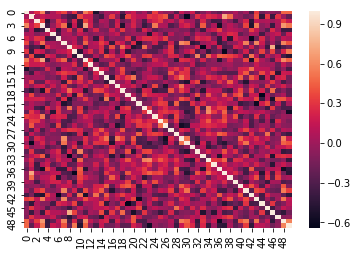

In [8]:
# seperate out the Categorical and Numerical features
import seaborn as sns

numerical_feature=trainX.dtypes[trainX.dtypes!= 'object'].index
categorical_feature=trainX.dtypes[trainX.dtypes== 'object'].index

print ("There are {} numeric and {} categorical columns in train data".format(numerical_feature.shape[0],categorical_feature.shape[0]))

corr=trainX[numerical_feature].corr()
sns.heatmap(corr)


In [9]:
from pandas import *
import numpy as np
from scipy.stats.stats import pearsonr
import itertools

# from https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(trainX, 5))

Top Absolute Correlations
8   46    0.740922
1   37    0.718052
3   11    0.712265
    48    0.650631
19  44    0.641989
dtype: float64


#  Create PyTorch GPU tensors from numpy arrays

- Note how we transfrom the np arrays

In [10]:
# Convert the np arrays into the correct dimention and type
# Note that BCEloss requires Float in X as well as in y
def XnumpyToTensor(x_data_np):
    x_data_np = np.array(x_data_np, dtype=np.float32)        
    print(x_data_np.shape)
    print(type(x_data_np))

    if use_cuda:
        lgr.info ("Using the GPU")    
        X_tensor = Variable(torch.from_numpy(x_data_np).cuda()) # Note the conversion for pytorch    
    else:
        lgr.info ("Using the CPU")
        X_tensor = Variable(torch.from_numpy(x_data_np)) # Note the conversion for pytorch
    
    print(type(X_tensor.data)) # should be 'torch.cuda.FloatTensor'
    print(x_data_np.shape)
    print(type(x_data_np))    
    return X_tensor


# Convert the np arrays into the correct dimention and type
# Note that BCEloss requires Float in X as well as in y
def YnumpyToTensor(y_data_np):    
    y_data_np=y_data_np.reshape((y_data_np.shape[0],1)) # Must be reshaped for PyTorch!
    print(y_data_np.shape)
    print(type(y_data_np))

    if use_cuda:
        lgr.info ("Using the GPU")            
    #     Y = Variable(torch.from_numpy(y_data_np).type(torch.LongTensor).cuda())
        Y_tensor = Variable(torch.from_numpy(y_data_np)).type(torch.FloatTensor).cuda()  # BCEloss requires Float        
    else:
        lgr.info ("Using the CPU")        
    #     Y = Variable(torch.squeeze (torch.from_numpy(y_data_np).type(torch.LongTensor)))  #         
        Y_tensor = Variable(torch.from_numpy(y_data_np)).type(torch.FloatTensor)  # BCEloss requires Float        

    print(type(Y_tensor.data)) # should be 'torch.cuda.FloatTensor'
    print(y_data_np.shape)
    print(type(y_data_np))    
    return Y_tensor

# The NN model

### MLP model
- A multilayer perceptron is a logistic regressor where instead of feeding the input to the logistic regression you insert a intermediate layer, called the hidden layer, that has a nonlinear activation function (usually tanh or sigmoid) . One can use many such hidden layers making the architecture deep.

- Here we define a simple MLP structure. We map the input feature vector to a higher space, then later gradually decrease the dimension, and in the end into a 1-dimension space. Because we are calculating the probability of each genre independently, after the final layer we need to use a sigmoid layer. 

###  Initial weights selection

- There are many ways to select the initial weights to a neural network architecture. A common initialization scheme is random initialization, which sets the biases and weights of all the nodes in each hidden layer randomly.

- Before starting the training process, an initial value is assigned to each variable. This is done by pure randomness, using for example a uniform or Gaussian distribution. But if we start with weights that are too small, the signal could decrease so much that it is too small to be useful. On the other side, when the parameters are initialized with high values, the signal can end up to explode while propagating through the network.

- In consequence, a good initialization can have a radical effect on how fast the network will learn useful patterns.For this purpose, some best practices have been developed. One famous example used is **Xavier initialization**. Its formulation is based on the number of input and output neurons and uses sampling from a uniform distribution with zero mean and all biases set to zero.

- In effect (according to theory) initializing the weights of the network to values that would be closer to the optimal, and therefore require less epochs to train.

### References: 
* **`nninit.xavier_uniform(tensor, gain=1)`** - Fills `tensor` with values according to the method described in ["Understanding the difficulty of training deep feedforward neural networks" - Glorot, X. and Bengio, Y.](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf), using a uniform distribution.
* **`nninit.xavier_normal(tensor, gain=1)`** - Fills `tensor` with values according to the method described in ["Understanding the difficulty of training deep feedforward neural networks" - Glorot, X. and Bengio, Y.](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf), using a normal distribution.
* **`nninit.kaiming_uniform(tensor, gain=1)`** - Fills `tensor` with values according to the method described in ["Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification" - He, K. et al.](https://arxiv.org/abs/1502.01852) using a uniform distribution.
* **`nninit.kaiming_normal(tensor, gain=1)`** - Fills `tensor` with values according to the method described in ["Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification" - He, K. et al.]


In [43]:
# p is the probability of being dropped in PyTorch

def ncrelu(x):
    return torch.cat([x.clamp(min=0),
                      x.clamp(max=0)], dim=1)

# NN params
DROPOUT_PROB = 0.95

LR = 0.005
MOMENTUM= 0.9
dropout = torch.nn.Dropout(p=1 - (DROPOUT_PROB))
sigmoid = torch.nn.Sigmoid()
tanh=torch.nn.Tanh()
relu=torch.nn.LeakyReLU()
# nc_relu=ncrelu()

lgr.info(dropout)

hiddenLayer1Size=256
hiddenLayer2Size=int(hiddenLayer1Size/2)
hiddenLayer3Size=int(hiddenLayer1Size/2)

linear1=torch.nn.Linear(N_FEATURES, hiddenLayer1Size, bias=True) 
torch.nn.init.xavier_uniform(linear1.weight)

linear2=torch.nn.Linear(hiddenLayer1Size, hiddenLayer2Size)
torch.nn.init.xavier_uniform(linear2.weight)

linear3=torch.nn.Linear(hiddenLayer2Size,1)
torch.nn.init.xavier_uniform(linear3.weight)

net = torch.nn.Sequential(linear1,nn.BatchNorm1d(hiddenLayer1Size),relu,
                          linear2,nn.BatchNorm1d(hiddenLayer2Size),relu,
                          linear3,sigmoid,                                                
                          )
lgr.info(net)  # net architecture

INFO:__main__:Dropout (p = 0.05)
INFO:__main__:Sequential (
  (0): Linear (50 -> 256)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
  (2): LeakyReLU (0.01)
  (3): Linear (256 -> 128)
  (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True)
  (5): LeakyReLU (0.01)
  (6): Linear (128 -> 1)
  (7): Sigmoid ()
)


In [44]:
# optimizer = torch.optim.SGD(net.parameters(), lr=0.02)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=5e-3)
#L2 regularization can easily be added to the entire model via the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=LR,weight_decay=5e-5) #  L2 regularization

loss_func=torch.nn.BCELoss() # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
# http://andersonjo.github.io/artificial-intelligence/2017/01/07/Cost-Functions/

if use_cuda:
    lgr.info ("Using the GPU")    
    net.cuda()
    loss_func.cuda()
#     cudnn.benchmark = True

lgr.info (optimizer)
lgr.info (loss_func)

INFO:__main__:Using the GPU
INFO:__main__:<torch.optim.adam.Adam object at 0x7f073701e690>
INFO:__main__:BCELoss (
)


#  Training in batches  + Measuring the performance of the deep learning model

INFO:__main__:Using the GPU
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
INFO:__main__:Using the GPU


(535713, 50)
<type 'numpy.ndarray'>
<class 'torch.cuda.FloatTensor'>
(535713, 50)
<type 'numpy.ndarray'>
(535713, 1)
<type 'numpy.ndarray'>
<class 'torch.cuda.FloatTensor'>
(535713, 1)
<type 'numpy.ndarray'>
<class 'torch.cuda.FloatTensor'> <class 'torch.cuda.FloatTensor'>
0 [ 0.78077847]
LOG_LOSS=0.801873941394, ROC_AUC=0.523784140868 
20 [ 0.69438124]
LOG_LOSS=0.693662677004, ROC_AUC=0.5276973205 
40 [ 0.69111037]
LOG_LOSS=0.69103782778, ROC_AUC=0.537554293622 
60 [ 0.69018471]
LOG_LOSS=0.690148024318, ROC_AUC=0.543813299946 
80 [ 0.68950421]
LOG_LOSS=0.689467232634, ROC_AUC=0.548661804164 
100 [ 0.68870306]
LOG_LOSS=0.688659631441, ROC_AUC=0.553969311277 
GPU: 230.338 seconds


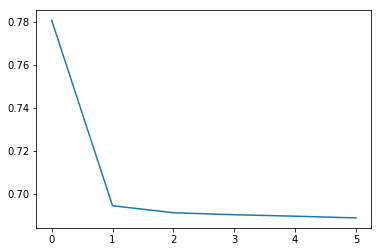

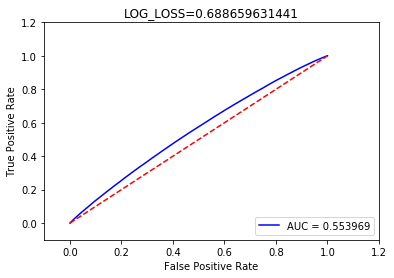

In [45]:
import time
start_time = time.time()    
epochs=120 # change to 400 for better results
all_losses = []

X_tensor_train= XnumpyToTensor(trainX)
Y_tensor_train= YnumpyToTensor(trainY)

print(type(X_tensor_train.data), type(Y_tensor_train.data)) # should be 'torch.cuda.FloatTensor'

# From here onwards, we must only use PyTorch Tensors
for step in range(epochs):    
    out = net(X_tensor_train)                 # input x and predict based on x
    cost = loss_func(out, Y_tensor_train)     # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()   # clear gradients for next train
    cost.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
                   
        
    if step % 20 == 0:        
        loss = cost.data[0]
        all_losses.append(loss)
        print(step, cost.data.cpu().numpy())
        # RuntimeError: can't convert CUDA tensor to numpy (it doesn't support GPU arrays). 
        # Use .cpu() to move the tensor to host memory first.        
        prediction = (net(X_tensor_train).data).float() # probabilities         
#         prediction = (net(X_tensor).data > 0.5).float() # zero or one
#         print ("Pred:" + str (prediction)) # Pred:Variable containing: 0 or 1
#         pred_y = prediction.data.numpy().squeeze()            
        pred_y = prediction.cpu().numpy().squeeze()
        target_y = Y_tensor_train.cpu().data.numpy()
                        
        tu = (log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
        print ('LOG_LOSS={}, ROC_AUC={} '.format(*tu))        
                
end_time = time.time()
print ('{} {:6.3f} seconds'.format('GPU:', end_time-start_time))

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.show()

false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LOG_LOSS=' + str(log_loss(target_y, pred_y)))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#  Performance of the deep learning model on the Validation set

INFO:__main__:Using the GPU


(73865, 50)
(73865,)
(73865, 50)
<type 'numpy.ndarray'>


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
INFO:__main__:Using the GPU


<class 'torch.cuda.FloatTensor'>
(73865, 50)
<type 'numpy.ndarray'>
(73865, 1)
<type 'numpy.ndarray'>
<class 'torch.cuda.FloatTensor'>
(73865, 1)
<type 'numpy.ndarray'>
<class 'torch.cuda.FloatTensor'> <class 'torch.cuda.FloatTensor'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


log_loss=0.694789081435 roc_auc=0.523875784081 


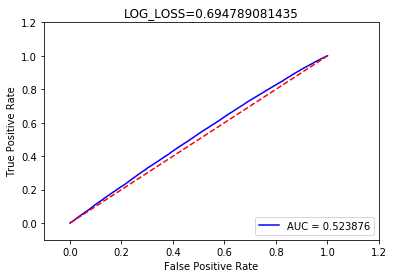

In [46]:
net.eval()
# Validation data
print (valX.shape)
print (valY.shape)

X_tensor_val= XnumpyToTensor(valX)
Y_tensor_val= YnumpyToTensor(valY)


print(type(X_tensor_val.data), type(Y_tensor_val.data)) # should be 'torch.cuda.FloatTensor'

predicted_val = (net(X_tensor_val).data).float() # probabilities 
# predicted_val = (net(X_tensor_val).data > 0.5).float() # zero or one
pred_y = predicted_val.cpu().numpy()
target_y = Y_tensor_val.cpu().data.numpy()                

print (type(pred_y))
print (type(target_y))

tu = (log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
print ('\n')
print ('log_loss={} roc_auc={} '.format(*tu))

false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LOG_LOSS=' + str(log_loss(target_y, pred_y)))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# print (pred_y)

#  Submission on Test set

In [62]:
# testX, df_test_set
# df[df.columns.difference(['b'])]
# trainX, trainY, valX, valY, testX, df_test_set = loadDataSplit()
    
print (df_test_set.shape)
columns = ['id', 'probability']
df_pred=pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)
# df_pred.id.astype(int)

for index, row in df_test_set.iterrows():
    rwo_no_id=row.drop('id')    
#     print (rwo_no_id.values)    
    x_data_np = np.array(rwo_no_id.values, dtype=np.float32)        
    if use_cuda:
        X_tensor_test = Variable(torch.from_numpy(x_data_np).cuda()) # Note the conversion for pytorch    
    else:
        X_tensor_test = Variable(torch.from_numpy(x_data_np)) # Note the conversion for pytorch
                    
    X_tensor_test=X_tensor_test.view(1, trainX.shape[1]) # does not work with 1d tensors            
    predicted_val = (net(X_tensor_test).data).float() # probabilities     
    p_test =   predicted_val.cpu().numpy().item() # otherwise we get an array, we need a single float
    
    df_pred = df_pred.append({'id':row['id'], 'probability':p_test},ignore_index=True)
#     df_pred = df_pred.append({'id':row['id'].astype(int), 'probability':p_test},ignore_index=True)

df_pred.head(5)

(349053, 51)


,id,probability
0,9403af5f3de44039,0.500649
1,67d84c8e966047d9,0.512502
2,12f1aa03af504e19,0.484780
3,e003f1be931040fa,0.527688
4,550cac2470fe4644,0.498883


#  Create a CSV with the ID's and the coresponding probabilities. 

In [63]:
# df_pred.id=df_pred.id.astype(int)

def savePred(df_pred, loss):
#     csv_path = 'pred/p_{}_{}_{}.csv'.format(loss, name, (str(time.time())))
    csv_path = 'pred/pred_{}_{}.csv'.format(loss, (str(time.time())))
    df_pred.to_csv(csv_path, columns=('id', 'probability'), index=None)
    print (csv_path)
    
savePred (df_pred, log_loss(target_y, pred_y))

pred/pred_0.691885044454_1505514269.99.csv


#  Actual score on Numer.ai - screenshot of the leader board

<img src="../images/numerai-score.jpg" width="35%" align="center">